In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.5  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

# matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, dashes=None, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    if linestyle == '--':
        ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize, dashes=dashes)
    else:
        ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])


In [2]:
from scalable_gps.data import get_protein_dataset, get_dataset

data_dir = "/home/sp2058/scalable-gaussian-processes/scalable_gps/datafiles"

train_ds, test_ds = get_protein_dataset("ESR2", dataset_dir=data_dir, input_dim=5, n_train=10000)
print(train_ds.x.shape)



Starting to load datasets...
/home/sp2058/scalable-gaussian-processes/scalable_gps/datafiles
Finished loading datasets.
(10000, 5)


(10000, 10000)
100 5
() (5,)
(10000, 100)
(10000, 10000)


/home/sp2058/.conda/envs/pnum3/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'numpy.integer'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


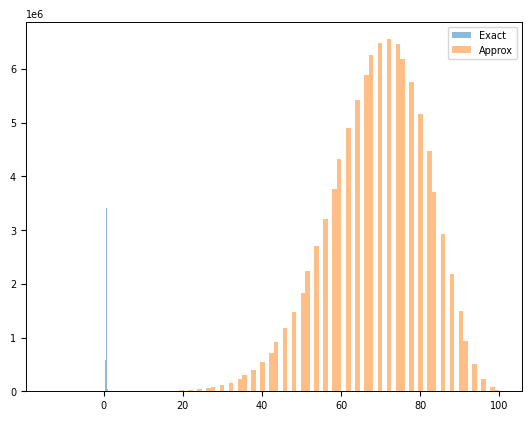

SyntaxError: 'break' outside loop (4119491131.py, line 35)

In [4]:
from scalable_gps.kernels import TanimotoKernel, RBFKernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.eval_utils import RMSE

from scalable_gps.utils import ExactPredictionsTuple

from scalable_gps.configs.default import get_config
import jax.random as jr
import matplotlib.pyplot as plt


kernel = TanimotoKernel(kernel_config={'signal_scale': 1.})

K = kernel.kernel_fn(train_ds.x, train_ds.x)

print(K.shape)

features = kernel.feature_fn(jr.PRNGKey(0), n_features=100, n_input_dims=train_ds.D, x=train_ds.x,
                             modulo_value=8)

print(features.shape)

K_approx = features @ features.T

print(K_approx.shape)

K = np.array(K)
K_approx = np.array(K_approx)

plt.hist(K.ravel(), bins=100, alpha=0.5, label='Exact')
plt.hist(K_approx.ravel(), bins=100, alpha=0.5, label='Approx')
plt.legend()
plt.show()

break
noise_scale = 0.01

config = get_config('pol')

exact_model = ExactGPModel(noise_scale, kernel)

exact_model.compute_representer_weights(train_ds)

print(exact_model.alpha.shape)
y_pred_exact = exact_model.predictive_mean(train_ds, test_ds)

test_rmse_exact = RMSE(
    test_ds.y, y_pred_exact, mu=train_ds.mu_y, sigma=train_ds.sigma_y
)

print("Test RMSE: {}".format(test_rmse_exact))

exact_metrics = ExactPredictionsTuple(
                alpha=exact_model.alpha, y_pred_loc=y_pred_exact
            )

In [ ]:
from scalable_gps.models.sgd_gp_model import SGDGPModel
import jax.random as jr


model = SGDGPModel(noise_scale, kernel)
train_config = config.train_config
config.compute_exact_soln = True
train_config.grad_variant = 'batch_kvp'

metrics_list = ["normalised_test_rmse"]
if config.compute_exact_soln:
    metrics_list.extend(["alpha_diff", "alpha_rkhs_diff", "y_pred_diff"])

optim_key = jr.PRNGKey(0)

alpha, aux = model.compute_representer_weights(
    optim_key,
    train_ds,
    test_ds,
    train_config,
    metrics_list=metrics_list,
    metrics_prefix="train",
    exact_metrics=exact_metrics if config.compute_exact_soln else None,
    artifact_name=None,
)

In [ ]:
y_pred = model.predictive_mean(train_ds, test_ds)
test_rmse = RMSE(test_ds.y, y_pred, mu=train_ds.mu_y, sigma=train_ds.sigma_y)
normalised_test_rmse = RMSE(test_ds.y, y_pred)

print("test_rmse = ", test_rmse)
print("normalised_test_rmse = ", normalised_test_rmse)

In [ ]:
print(aux)